# Figure S2c

### Import libraries

In [1]:
import anndata
import cellplots as cp
import larry
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scdiffeq as sdq
import scdiffeq_analyses as sdq_an
import scipy.stats
import seaborn as sns
import sklearn
import torch
import umap

### Read data

This version of the LARRY dataset has not been split for test and train

In [2]:
def download_in_vitro_adata():
    in_vitro = larry.datasets.inVitroData()
    adata = in_vitro.compose_adata()
    return adata

In [3]:
adata = download_in_vitro_adata()

- [ INFO ] | Added lineage x fate counts to: adata.uns['fate_counts']
- [ INFO ] | Added lineage-time occupance to: adata.uns['time_occupance']
- [ INFO ] | Fated cells annotated at: adata.obs['fate_observed']
- [ INFO ] | Fated cells (t=t0) annotated at: adata.obs['t0_fated']
- [ INFO ] | Added cell x fate counts to: adata.obsm['cell_fate_df']


In [4]:
larry.datasets.klein_lab_pp_recipe.highly_variable_genes(adata)

In [5]:
larry.datasets.klein_lab_pp_recipe.remove_cell_cycle_correlated_genes(adata)

  0%|          | 0/8 [00:00<?, ?it/s]

In [6]:
adata

AnnData object with n_obs × n_vars = 130887 × 25289
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone_idx', 'fate_observed', 't0_fated'
    var: 'gene_ids', 'hv_genes', 'use_genes'
    uns: 'fate_counts', 'time_occupance'
    obsm: 'X_clone', 'cell_fate_df'

In [7]:
adata = adata[:, adata.var['use_genes']].copy()

In [9]:
adata.obs['train'] = adata.obs['Time point'].isin([2, 6])
adata.obs['test'] = adata.obs['Time point'].isin([4])

X_train = adata[adata.obs['train']].X
X_test = adata[adata.obs['test']].X

In [10]:
ScalerModel = sklearn.preprocessing.StandardScaler()
PCAModel = sklearn.decomposition.PCA(n_components=50)
UMAPModel = umap.UMAP(n_components=2)

In [11]:
X_train_scaled = ScalerModel.fit_transform(X_train.A)
X_test_scaled = ScalerModel.transform(X_test.A)

In [12]:
X_train_pca = PCAModel.fit_transform(X_train_scaled)
X_test_pca = PCAModel.transform(X_test_scaled)

In [13]:
X_train_umap = UMAPModel.fit_transform(X_train_pca)
X_test_umap = UMAPModel.transform(X_test_pca)

In [14]:
adata_train = adata[adata.obs['train']].copy()
adata_test = adata[adata.obs['test']].copy()

adata_train.obsm['X_pca'] = X_train_pca
adata_train.obsm['X_umap'] = X_train_umap

adata_test.obsm['X_pca'] = X_test_pca
adata_test.obsm['X_umap'] = X_test_umap

adata_train.write_h5ad("adata_train.interpolation.larry.h5ad")
adata_test.write_h5ad("adata_test.interpolation.larry.h5ad")

In [44]:
def _subset(adata_train, adata_test, t: int):
    
    train_subset_idx = adata_train.obs.loc[adata_train.obs['Time point'] == t].index
    test_subset_idx = adata_test.obs.loc[adata_test.obs['Time point'] == t].index
    subset_train_X_pca = adata_train[train_subset_idx].obsm['X_pca']
    subset_test_X_pca = adata_test[test_subset_idx].obsm['X_pca']
    if t in [2, 6]:
        return subset_train_X_pca
    else:
        return subset_test_X_pca

In [45]:
Subsets = {}
for t in [2, 4, 6]:
    Subsets[t] = _subset(adata_train, adata_test, t = t)

In [17]:
sinkhorn = sdq.core.lightning_models.base.SinkhornDivergence()

In [18]:
def compute_distance(X_pca_train, X_pca_test, N: int = 10, batch_size: int = 2048):
    dist = {}
    X_train = torch.Tensor(X_pca_train)
    X_test = torch.Tensor(X_pca_test)
    for i in range(N):    
        x_train_idx = np.random.choice(range(len(X_train)), batch_size)
        x_test_idx = np.random.choice(range(len(X_test)), batch_size)
        X_train_ = X_train[x_train_idx].to("cuda:0")
        X_test_ = X_test[x_test_idx].to("cuda:0")
        dist[i] = sinkhorn(X_train_, X_test_).detach().cpu().numpy()
    return pd.Series(dist)

In [58]:
Distances = {}
for ti, xi in Subsets.items():
    Distances[ti] = {}
    for tj, xj in Subsets.items():
        Distances[ti][tj] = compute_distance(Subsets[ti], Subsets[tj], N = 25, batch_size = 2048)
    print(ti, tj)
    _df = pd.DataFrame(Distances[ti])
    Distances[ti] = pd.DataFrame({"mean": _df.mean(), "std": _df.std()})

2 6
4 6
6 6


Distances from `d2`

In [59]:
Distances[2]

,mean,std
2,71.480229,21.516475
4,111.91,21.165441
6,193.299004,24.485301


Distances from `d4`

In [60]:
Distances[4]

,mean,std
2,106.150371,14.005153
4,36.726067,4.526217
6,75.11978,13.393704


Distances from `d6`

In [61]:
Distances[6]

,mean,std
2,179.370742,15.866916
4,75.829014,10.470971
6,36.949607,5.756697


In [62]:
time_cmap = sdq_an.pl.generate_temporal_cmap()

In [63]:
t_coarse = time_cmap.colors[2:-2][::18]
t_coarse

array([[0.979644, 0.854866, 0.142453],
       [0.801855, 0.284626, 0.465971],
       [0.227983, 0.016007, 0.604867]])

### Plot d2, d6 (`train`)

/home/mvinyard/.anaconda3/envs/sdq/lib/python3.9/site-packages/cellplots/core/_umap.py:194: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_umap[:, 0], X_umap[:, 1], **KWARGS)
/home/mvinyard/.anaconda3/envs/sdq/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(


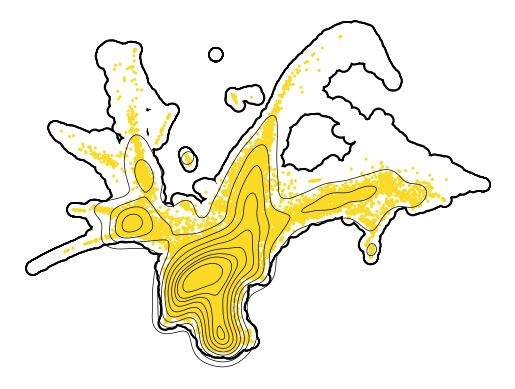

/home/mvinyard/.anaconda3/envs/sdq/lib/python3.9/site-packages/cellplots/core/_umap.py:194: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_umap[:, 0], X_umap[:, 1], **KWARGS)
/home/mvinyard/.anaconda3/envs/sdq/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(


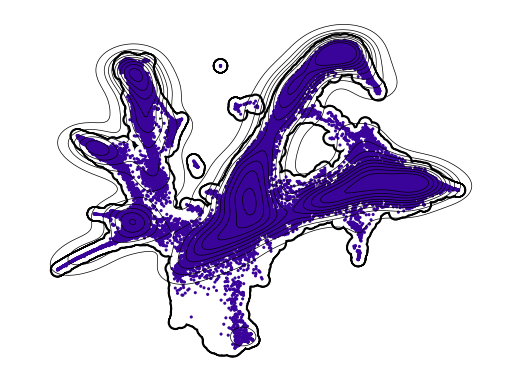

In [64]:
for en, t in enumerate([2, 4, 6]):
    if t != 4:
        axes = cp.umap_manifold(adata_train)
        cp.umap(adata_train[adata_train.obs['Time point'] == t], ax = axes[0], s = 5, c = t_coarse[en])
        xu = adata_train[adata_train.obs['Time point'] == t].obsm['X_umap']
        sns.kdeplot(x = xu[:,0], y = xu[:,1], c = "k", ax=axes[0], zorder = 301, linewidths=0.5)
        plt.savefig(f"train.interpolation.timepoint_{t}.svg", dpi = 250)
        plt.savefig(f"train.interpolation.timepoint_{t}.png")
        plt.show()

### Plot d4 (`test`)

/home/mvinyard/.anaconda3/envs/sdq/lib/python3.9/site-packages/cellplots/core/_umap.py:194: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_umap[:, 0], X_umap[:, 1], **KWARGS)
/home/mvinyard/.anaconda3/envs/sdq/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(


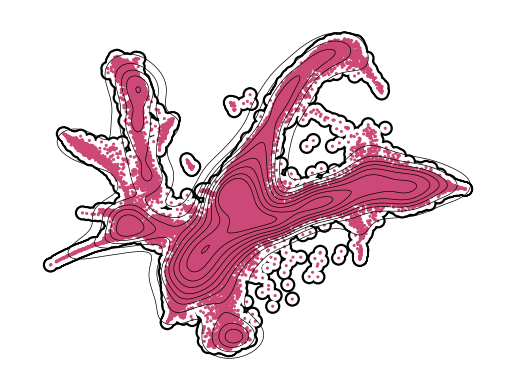

In [65]:
for en, t in enumerate([2, 4, 6]):
    if t == 4:
        axes = cp.umap_manifold(adata_test)
        cp.umap(adata_test[adata_test.obs['Time point'] == t], ax = axes[0], s = 5, c = t_coarse[en])
        xu = adata_test[adata_test.obs['Time point'] == t].obsm['X_umap']
        sns.kdeplot(x = xu[:,0], y = xu[:,1], c = "k", ax=axes[0], zorder = 301, linewidths=0.5)
        plt.savefig(f"test.timepoint_{t}.svg", dpi = 250)
        plt.savefig(f"test.timepoint_{t}.png")
        plt.show()